# Dynamic Content Personalization Using LinUCB

This is a reference implementation of recommendation system that dynamically learns the mapping between users and items that maximizes conversion rates. 

| Papers | Li2010 (see [papers](https://github.com/ikatsov/tensor-house/blob/master/resources/papers.md)) | 
|--|:--|
| Dataset | Simulator, no external dependencies |
| Libs | Numpy, Scikit-learn |

In [259]:
import numpy as np
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("whitegrid")

# Step 1: Create a Simple User Behavior Simulator

First, we delop a simple environment simulator. 

We assume that an online store that sells polo shirts and raincoats. The recommender system shows one recommendation, either polo or raincoat, to each user. 
The user can either ignore the recommendation or click on it. 

Users come either from Seattle and Miami. Ones who come from Seattle tend to buy raincoats, ones who come from  Miami tend to buy polo shirts. 
We assume user locations are known, and we also assume that each user fills a short form and discloses hir or her age.

The goal of the recommendation system is to map a user feature vector (location and age) to recommednation (polo or raincoat) is a way that maximizes the average conversion rate (click rate).

We assume the cold start scenario, so that the system has no prior knowledge about user behavior. 

In [225]:
#
# We assume that the click probability depends on location, age, 
# and offer. More specifically, raincoats have higher conversion 
# rates than polos in Seattle, but lower in Miami:
#
#  location | age | recommendation | click probability
#  ---------+-----+----------------+-------------------
#  seattle  | 20  | polo             => 0.3
#  seattle  | 20  | raincoat         => 0.4
#  seattle  | 60  | polo             => 0.1
#  seattle  | 60  | raincoat         => 0.5 
#  maimi    | 20  | polo             => 0.4
#  maimi    | 20  | raincoat         => 0.1
#  maimi    | 60  | polo             => 0.6
#  maimi    | 60  | raincoat         => 0.2 
#
# This dependency is not linear, so we 
# add an interaction feature (location x item) to make 
# it tractable for a linear regression model
    
x = [[0, 20, 1, 0],
     [0, 20, 0, 0],
     [0, 60, 1, 0],
     [0, 60, 0, 0],
     [1, 20, 1, 1],
     [1, 20, 0, 0],
     [1, 60, 1, 1],
     [1, 60, 0, 0]]
y = [0.3, 0.4, 0.1, 0.5, 0.4, 0.1, 0.6, 0.2]

reg = LinearRegression().fit(x, y)
print(f'Actual probabilities    {y}')
print(f'Predicted probabilities {reg.predict(x)}')
print(f'Regression intercept {reg.intercept_}, coefficients {reg.coef_}')

Actual probabilities    [0.3, 0.4, 0.1, 0.5, 0.4, 0.1, 0.6, 0.2]
Predicted probabilities [0.175 0.425 0.225 0.475 0.475 0.125 0.525 0.175]
Regression intercept 0.400000000000001, coefficients [-0.3      0.00125 -0.25     0.6    ]


In [260]:
# Dimensionality of the context vector 
context_size = 4

# Create a context vector from user and action (content) vectors
def context(user, action):
    return np.array([user['location'], user['age'], action, user['location'] * action])

#
# Recommendation environment
#
class RecommendationEnvironment():
    # we implement the linear user model specified above  
    def __init__(self):
        self.theta = [-0.30, 0.00125, -0.25, 0.60]
        self.p = lambda context: 0.4 + np.dot(self.theta, context)
    
    # let's assume that 70% of users come from Seattle, age is uniform in [18, 80] years
    def next_user(self):
        return {'location': np.random.choice([0, 1], p=[0.7, 0.3]), 'age': np.random.randint(18, 80)}
    
    def act(self, user, action):
        ctx = context(user, action)
        return 1 if np.random.random() < self.p(ctx) else 0 
    
    def best_action(self, user, actions):
        return np.argmax([self.p(context(user, action)) for action in actions])

# Step 2: Create a Baseline Recommendation Agent - UCB

In [347]:
class UCBAgent():
    def __init__(self):
        self.actions = [0, 1]   # action space. The actions here are scalars, but can be vectors as well.
        self.n_actions = len(self.actions)
        self.action_total_rewards = np.zeros(self.n_actions)
        self.action_counters = np.ones(self.n_actions)
        self.alpha = 0.5

    def get_ucbs(self):
        ucbs = np.zeros(self.n_actions)
        for action_idx, action in enumerate(self.actions):
            steps = np.sum(self.action_counters)
            mean_reward_a = self.action_total_rewards[action_idx]/steps
            bound_a = np.sqrt(self.alpha * np.log(steps) / self.action_counters[action_idx])
            ucbs[action_idx] = mean_reward_a + bound_a
        return ucbs
    
    def choose_action(self, user): # user vector is not used (context-free agent)
        ucbs = self.get_ucbs()
        return self.actions[np.argmax(ucbs)]
    
    def observe(self, user, reward, action):
        action_idx = self.actions.index(action)
        self.action_total_rewards[action_idx] += reward
        self.action_counters[action_idx] += 1

# Step 3: Create a Context-aware Agent - LinUCB

In [348]:
class LinUCBAgent(object):
    def __init__(self):
        self.actions = [0, 1]  
        self.n_actions = len(self.actions)
        self.alpha = 0.5
        self.A = [np.identity(context_size) for a in range(self.n_actions)]
        self.b = [np.zeros((context_size, 1)) for a in range(self.n_actions)]

    def get_ucbs(self, user):
        ucbs = np.zeros(self.n_actions)
        for action_idx, action in enumerate(self.actions):
            x_a = context(user, action)
            A_inv = np.linalg.inv(self.A[action_idx])
            theta_a = np.dot(A_inv, self.b[action_idx])
            ucb = np.dot(theta_a.T, x_a) + self.alpha * np.sqrt(np.linalg.multi_dot([x_a.T, A_inv, x_a]))
            ucbs[action_idx] = ucb[0]
        return ucbs
    
    def choose_action(self, user): # user vector is used       
        ucbs = self.get_ucbs(user)
        return self.actions[np.argmax(ucbs)]
    
    def observe(self, user, reward, action):
        action_idx = self.actions.index(action)
        x = np.atleast_2d(context(user, action))
        self.A[action_idx] += np.dot(x.T, x)
        self.b[action_idx] += reward * np.atleast_2d(x).T

# Step 4: Run Agents and Compare Their Performance

In [341]:
n_simulations = 500
n_steps = 200

def simulate(agent_class):
    trace = np.zeros((n_simulations, n_steps, 3))
    env = RecommendationEnvironment()
    for sim in range(n_simulations):
        agent = agent_class()
        for i in range(n_steps):
            user = env.next_user()
            action = agent.choose_action(user)
            reward = env.act(user, action)
            agent.observe(user, reward, action)
            trace[sim, i, :] = [action, env.best_action(user, agent.actions), reward]
    return trace

ucb_trace = simulate(UCBAgent)
linucb_trace = simulate(LinUCBAgent)

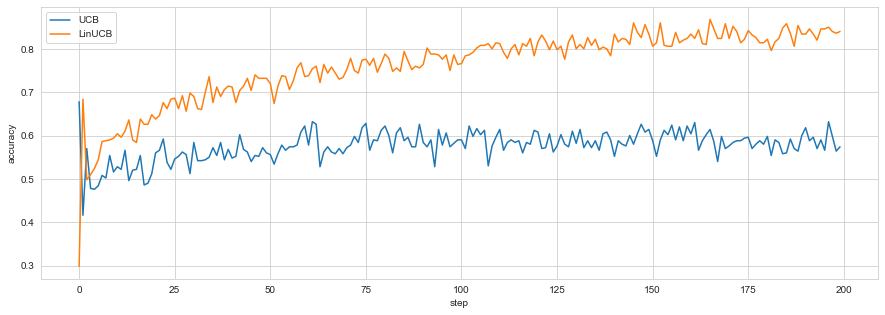

In [342]:
#
# let's visualize the accuracy: the fraction of recommendations generated by the agent 
# that matches the best possible action for a given customer (ground truth)
#
fix, ax = plt.subplots(1, figsize=(15, 5))
ax.plot(np.mean(ucb_trace[:, :, 0]==ucb_trace[:, :, 1], axis=0), label='UCB')
ax.plot(np.mean(linucb_trace[:, :, 0]==linucb_trace[:, :, 1], axis=0), label='LinUCB')
ax.set_xlabel('step')
ax.set_ylabel('accuracy')
ax.legend();

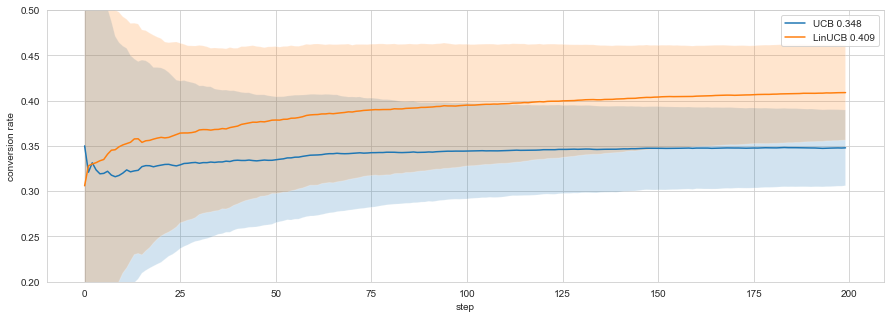

In [346]:
#
# let's visualize the actual conversion rates (click rates) for both agents
#
def cumulative_conversion_rate(trace):
    ongoing_rate = np.cumsum(trace[:, :, 2], axis=1)/np.linspace(1, n_steps, n_steps)
    return np.mean(ongoing_rate, axis=0), np.std(ongoing_rate, axis=0)

fix, ax = plt.subplots(1, figsize=(15, 5))
x = range(n_steps)

ucb_mean, ucb_std = cumulative_conversion_rate(ucb_trace)
ax.plot(x, ucb_mean, label=f'UCB {ucb_mean[-1]:.3}')
ax.fill_between(x, ucb_mean + ucb_std, ucb_mean - ucb_std, alpha=0.2)

linucb_mean, linucb_std = cumulative_conversion_rate(linucb_trace)
ax.plot(x, linucb_mean, label=f'LinUCB {linucb_mean[-1]:.3}')
ax.fill_between(x, linucb_mean + linucb_std, linucb_mean - linucb_std, alpha=0.2)

ax.set_xlabel('step')
ax.set_ylabel('conversion rate')
ax.set_ylim([0.2, 0.5])
ax.legend();

# Step 5: Off-policy Agent Training and Evaluation

In [335]:
n_simulation = 500
conversion_rates_ucb = np.zeros(n_simulation)
conversion_rates_linucb = np.zeros(n_simulation)
for sim in range(n_simulation):
    #
    # execute UCB policy in 'production' and record logs (trace) with users, actions, and rewards
    #
    ucb_trace = []
    env = RecommendationEnvironment()
    agent = UCBAgent()
    for i in range(n_steps):
        user = env.next_user()
        action = agent.choose_action(user)
        reward = env.act(user, action)
        agent.observe(user, reward, action)
        ucb_trace.append([user, action, reward])
       
    #
    # train a LinUCB policy on 'production' logs and estimate 
    # its performance using actions that matched UCB's actions
    #
    linucb_trace = []
    agent = LinUCBAgent()
    for i in range(n_steps):
        user = ucb_trace[i][0]
        action = agent.choose_action(user)
        if action == ucb_trace[i][1]:
            reward = env.act(user, action)
            agent.observe(user, reward, action)
            linucb_trace.append(reward)
        
    conversion_rates_ucb[sim] = np.mean([ucb_trace[i][2] for i in range(n_steps)])
    conversion_rates_linucb[sim] = np.mean(linucb_trace)

In [336]:
print(f'Mean conversion rates\n UCB: {np.mean(conversion_rates_ucb):.3}\n LinUCB: {np.mean(conversion_rates_linucb):.3}')

Mean conversion rates
 UCB: 0.351
 LinUCB: 0.407


In [337]:
# Note that the conversion rate for LinUCB obtained using 
# offline evaluation matches the conversion rate for 
# environment-based simulation in the previous step. 